# 0. Import packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00


In [4]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.9 MB/s eta 0:00:00


In [5]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
from optuna.integration import XGBoostPruningCallback
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from scipy import stats


# 1. Load Base Datasets

In [6]:
INPUT_DIR='/content/drive/MyDrive/Colab Notebooks/IE343 competition'
OUTPUT_DIR='/content/drive/MyDrive/Colab Notebooks/IE343 competition'

In [58]:
## Do not change this cell. 
## The reason for this is to prevent cheating using the original data from DACON. 
## If an assertion error occurs in that cell when TAs evaluate the submitted code of each student, it is considered cheating.

train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
park = pd.read_csv(os.path.join(INPUT_DIR, 'park.csv'))
dcc = pd.read_csv(os.path.join(INPUT_DIR, 'day_care_center.csv'))

assert train.shape[0] == 329690 and train.shape[1] == 13, 'Do not change the format of the input data.'
assert test.shape[0] == 85097 and test.shape[1] == 12, 'Do not change the format of the input data.'
assert park.shape[0] == 1359 and park.shape[1] == 7, 'Do not change the format of the input data.'
assert dcc.shape[0] == 7373 and dcc.shape[1] == 10, 'Do not change the format of the input data.'
print(train.shape, test.shape, park.shape, dcc.shape)

(329690, 13) (85097, 12) (1359, 7) (7373, 10)


In [59]:
print(train.shape, test.shape, park.shape, dcc.shape)

(329690, 13) (85097, 12) (1359, 7) (7373, 10)


# 2. Load additional dataset
- You can use any additional data source, **excluding the original dataset from [DACON](https://dacon.io/competitions/open/21265/data)**

In [60]:
train

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,PRICE
0,0,0,busan,197,125.865988,1993,5,35.149929,129.006071,2021,7,11~20,229250.80
1,1,0,busan,197,101.647190,1993,12,35.149929,129.006071,2021,10,1~10,215320.00
2,2,0,busan,197,91.511175,1993,6,35.149929,129.006071,2020,3,21~31,161740.00
3,3,0,busan,197,101.647190,1993,13,35.149929,129.006071,2020,5,11~20,199781.80
4,4,0,busan,197,101.647190,1993,4,35.149929,129.006071,2022,6,21~30,219606.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329685,329685,4419,seoul,37,101.431912,2014,4,37.452039,127.070842,2022,5,21~31,885070.00
329686,329686,4419,seoul,37,101.431912,2014,14,37.452039,127.070842,2021,10,1~10,826132.00
329687,329687,4419,seoul,37,71.687641,2014,2,37.452039,127.070842,2022,11,21~30,697540.00
329688,329688,4419,seoul,37,137.192013,2014,18,37.452039,127.070842,2020,9,21~30,870656.98


In [61]:
test

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day
0,329690,0,busan,197,101.647190,1993,3,35.149929,129.006071,2023,1,21~31
1,329691,0,busan,197,91.511175,1993,12,35.149929,129.006071,2023,2,1~10
2,329692,0,busan,197,125.865988,1993,2,35.149929,129.006071,2023,2,11~20
3,329693,0,busan,197,101.647190,1993,8,35.149929,129.006071,2023,2,21~28
4,329694,0,busan,197,101.647190,1993,13,35.149929,129.006071,2023,3,21~31
...,...,...,...,...,...,...,...,...,...,...,...,...
85092,414782,4419,seoul,37,100.821957,2014,8,37.452039,127.070842,2023,10,21~31
85093,414783,4419,seoul,37,101.431912,2014,11,37.452039,127.070842,2023,10,21~31
85094,414784,4419,seoul,37,121.201627,2014,12,37.452039,127.070842,2023,11,1~10
85095,414785,4419,seoul,37,137.192013,2014,3,37.452039,127.070842,2023,11,21~30


# 3. EDA and Preprocessing

In [62]:
train.isnull().sum() #check to see if we have null values

index                 0
apartment_id          0
city                  0
dong                  0
house_area            0
built_year            0
floor                 0
lat                  89
long                 89
transaction_year      0
transaction_month     0
transaction_day       0
PRICE                 0
dtype: int64

<Axes: xlabel='city'>

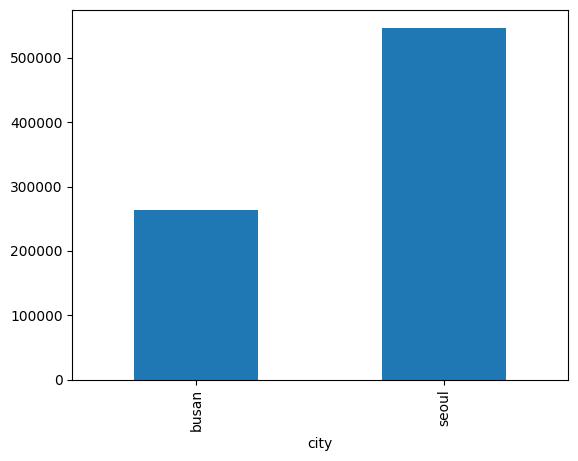

In [63]:
df = train.groupby("city").mean()["PRICE"]   # compare the difference in mean price between the two cities, we can see that in average an apartment in Seoul is more expensive than in Busan
df.plot.bar()

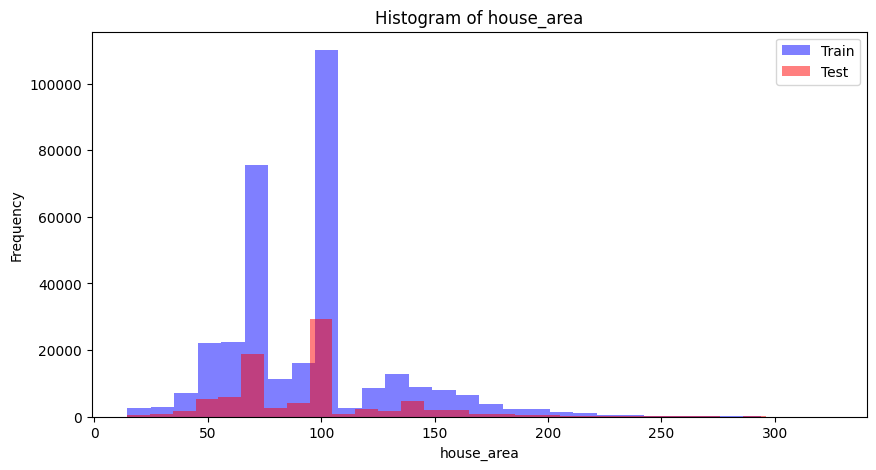

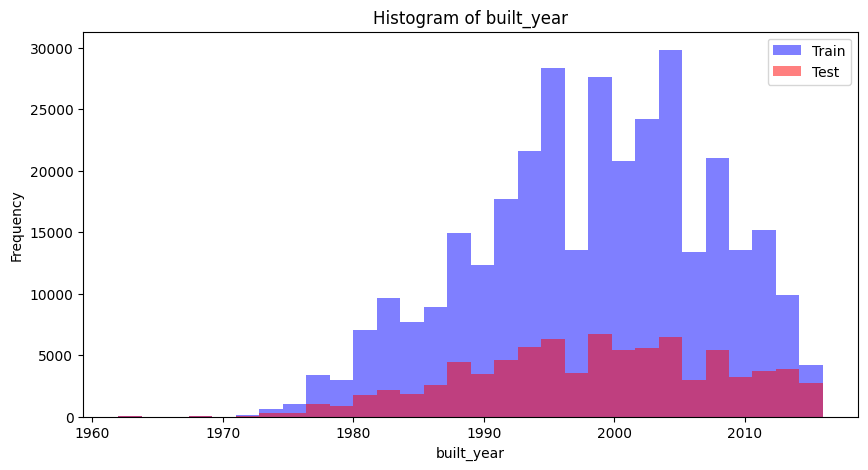

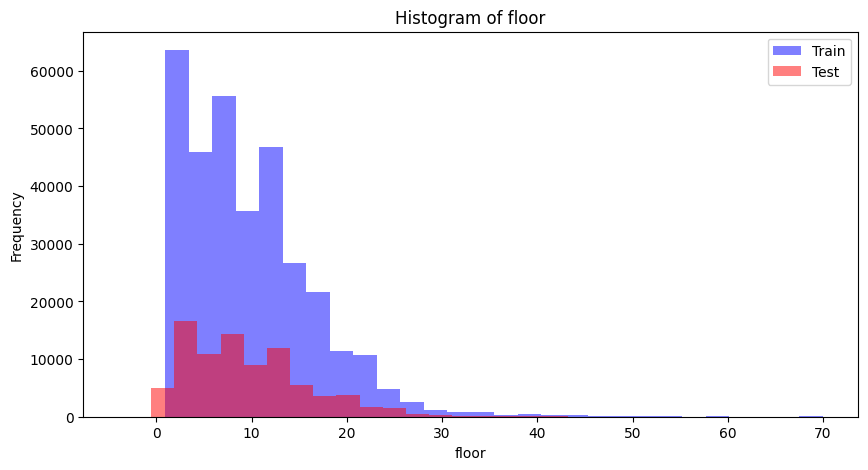

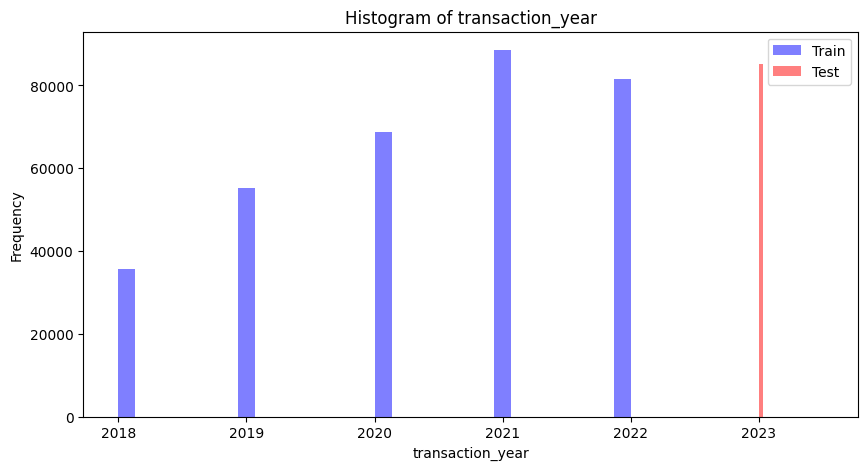

In [64]:
variables = ['house_area', 'built_year', 'floor', 'transaction_year'] #compare the 2 datasets. Notice that for the test dataset the transaction year is just 2023.

for var in variables:
    plt.figure(figsize=(10,5))
    plt.hist(train[var], bins=30, alpha=0.5, color='b', label='Train')
    plt.hist(test[var], bins=30, alpha=0.5, color='r', label='Test')
    plt.title('Histogram of '+var)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

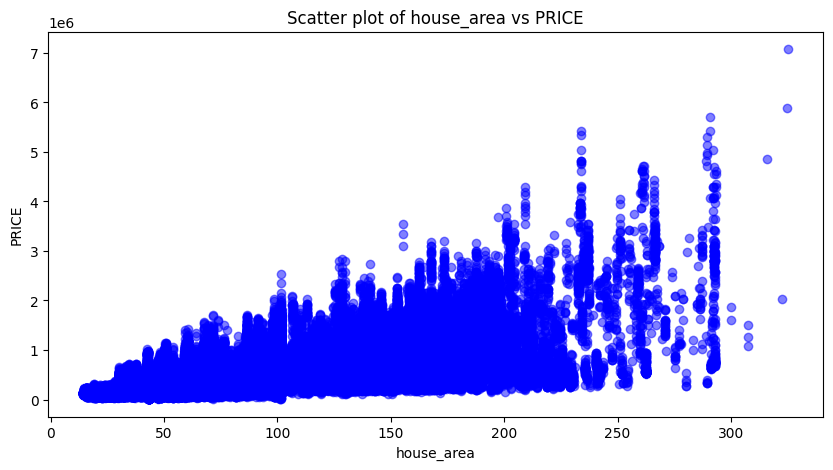

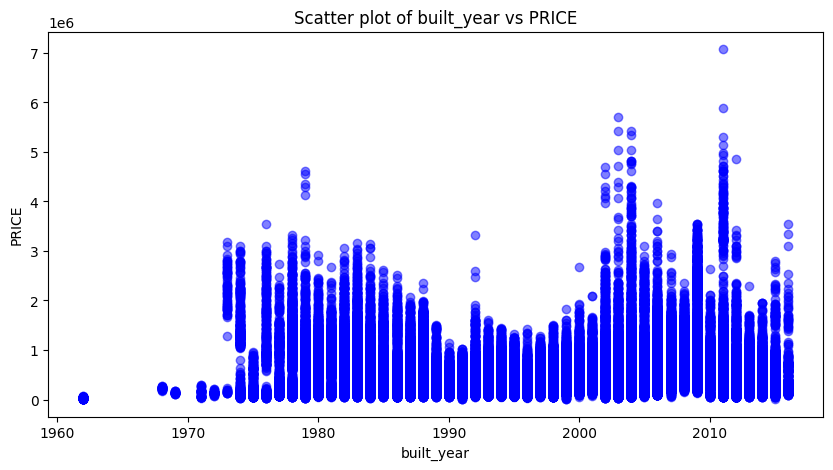

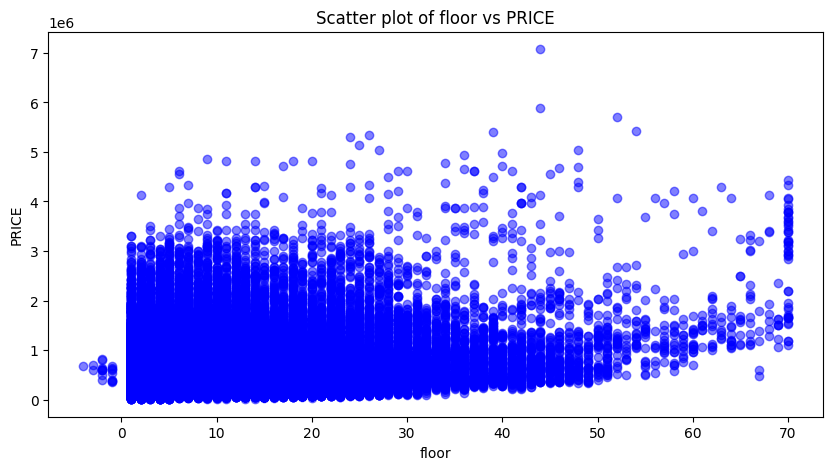

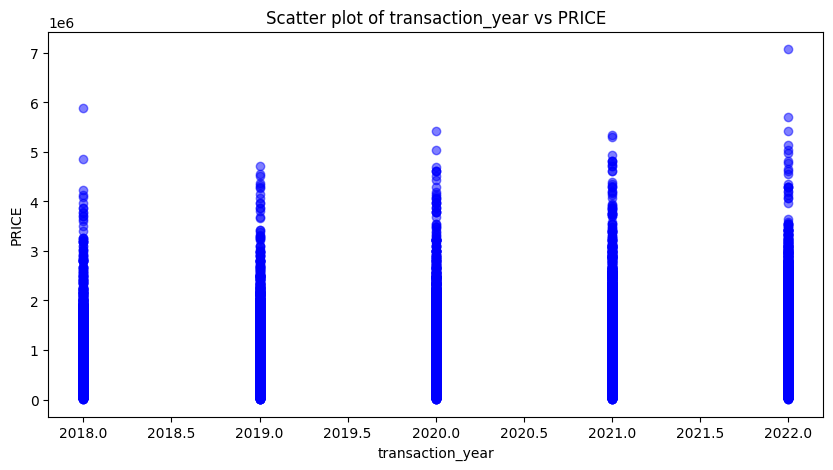

In [65]:
variables = ['house_area', 'built_year', 'floor', 'transaction_year'] #Scatterplots of a parameter vs. price

for var in variables:
    plt.figure(figsize=(10,5))
    plt.scatter(train[var], train['PRICE'], alpha=0.5, color='b')
    plt.title('Scatter plot of ' + var + ' vs PRICE')
    plt.xlabel(var)
    plt.ylabel('PRICE')
    plt.show()

In [66]:
train.dtypes

index                  int64
apartment_id           int64
city                  object
dong                   int64
house_area           float64
built_year             int64
floor                  int64
lat                  float64
long                 float64
transaction_year       int64
transaction_month      int64
transaction_day       object
PRICE                float64
dtype: object

In [68]:
display(train.select_dtypes('object'))

,city,transaction_day
0,busan,11~20
1,busan,1~10
2,busan,21~31
3,busan,11~20
4,busan,21~30
...,...,...
329685,seoul,21~31
329686,seoul,1~10
329687,seoul,21~30
329688,seoul,21~30


In [70]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_cols = list(train.select_dtypes('object'))

for col in le_cols:
    le.fit(train[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

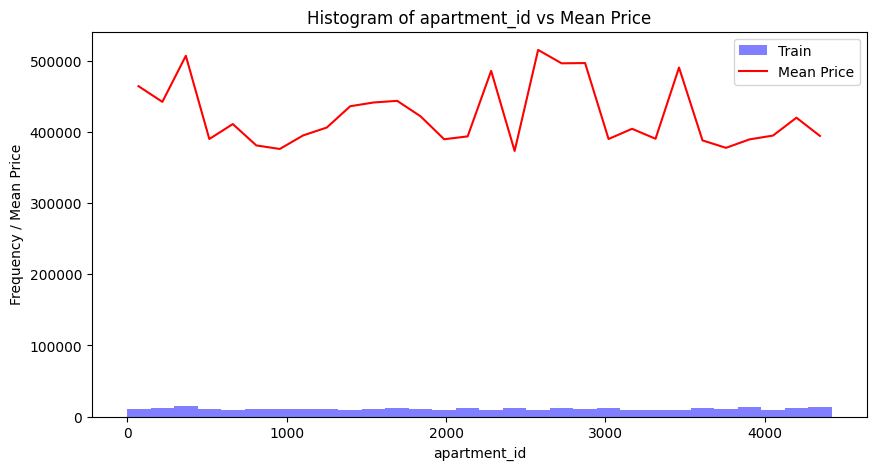

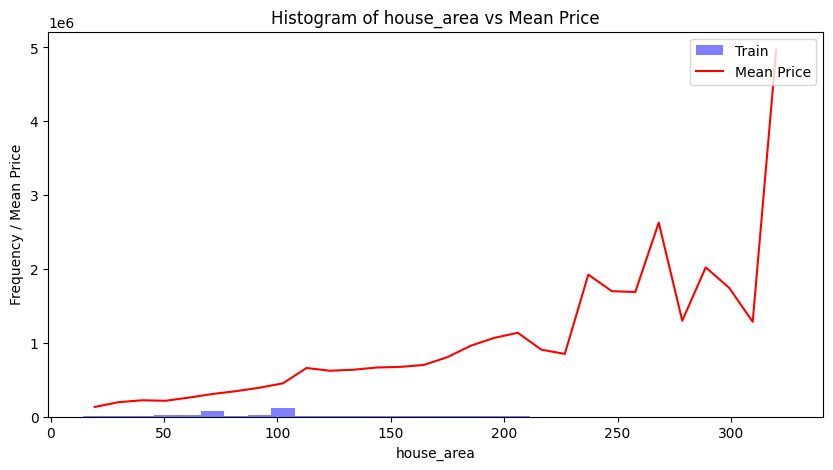

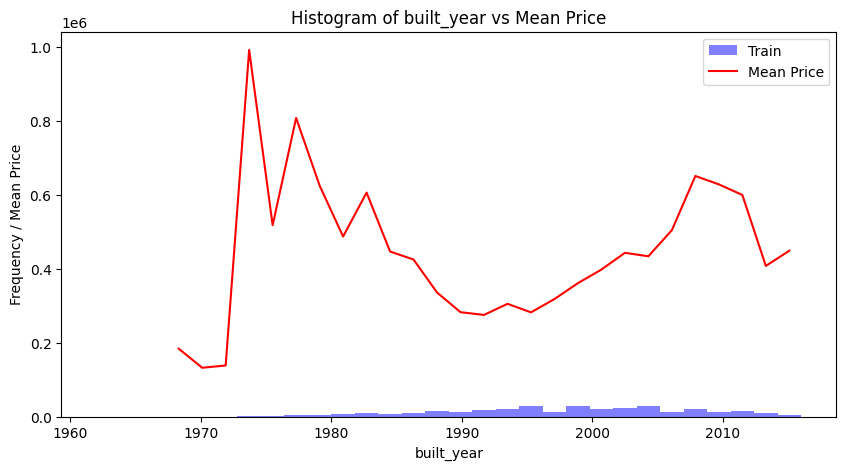

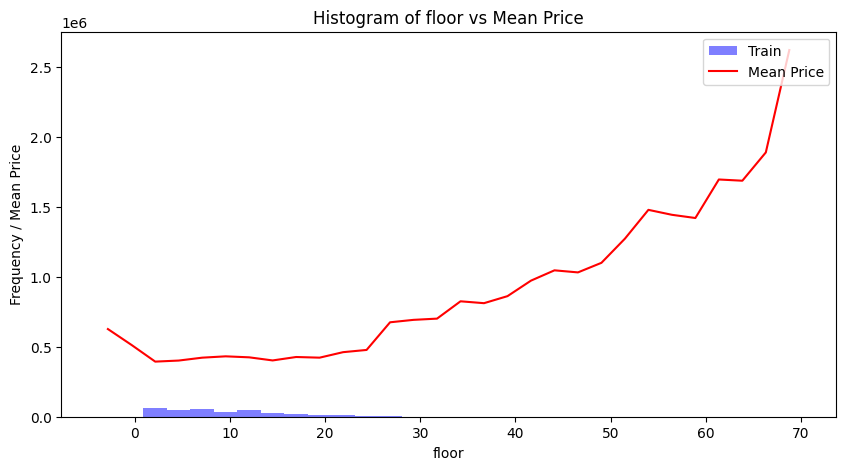

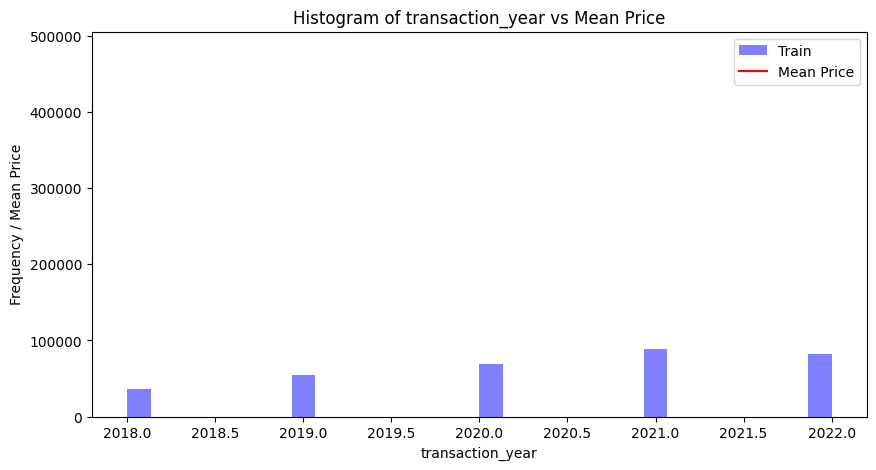

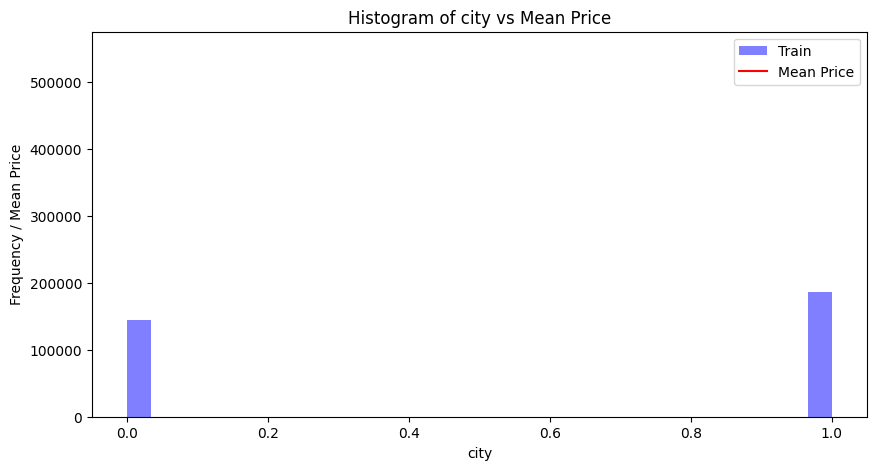

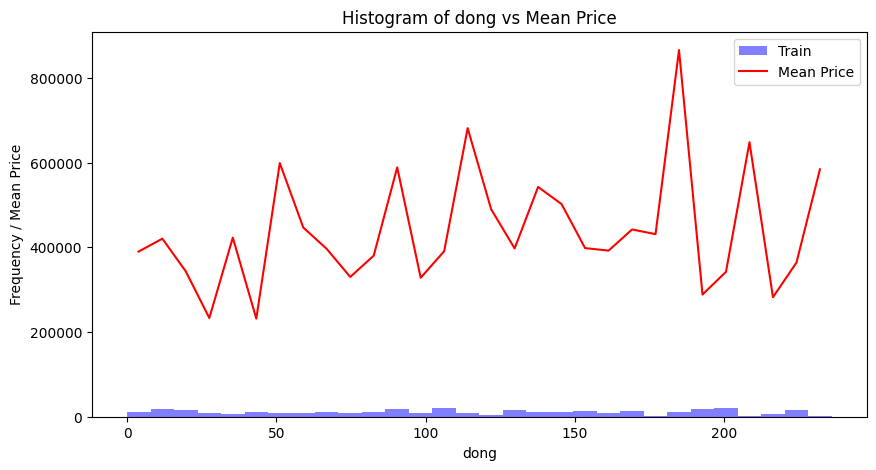

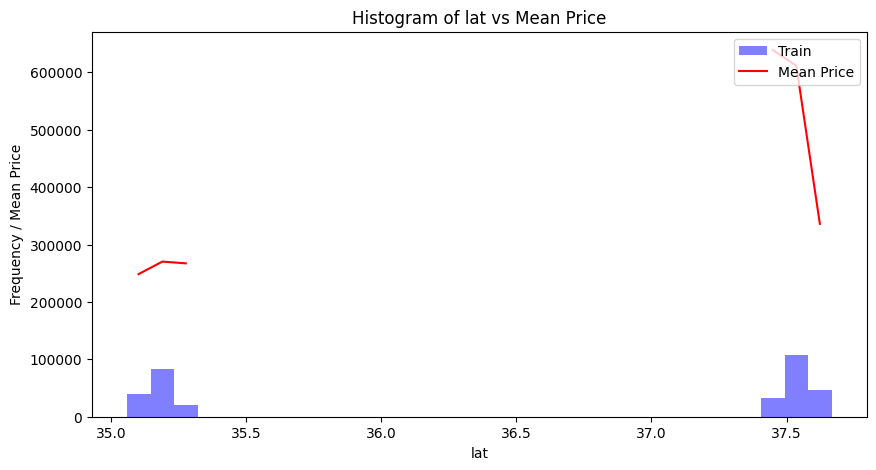

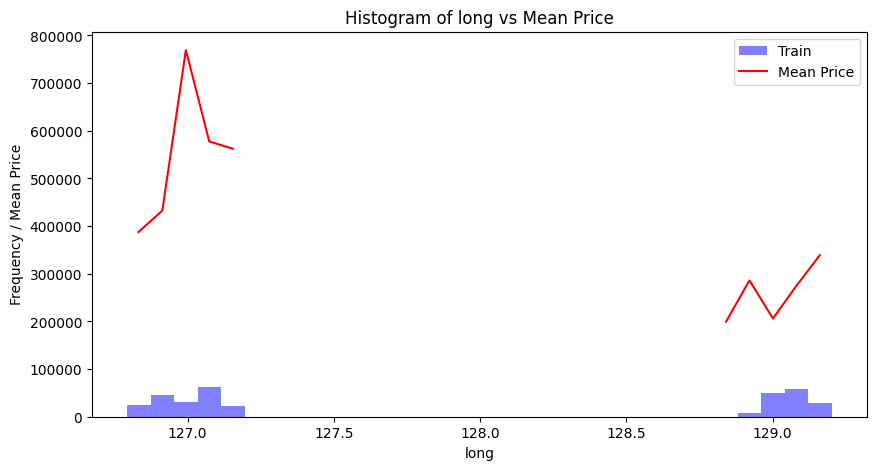

In [71]:
import matplotlib.pyplot as plt

variables = ['apartment_id', 'house_area', 'built_year', 'floor', 'transaction_year', 'city', 'dong', 'lat', 'long']

# Create histograms for each variable versus mean price
for var in variables:
    plt.figure(figsize=(10, 5))
    
    # Plot histogram for 'var' in train dataset
    plt.hist(train[var], bins=30, alpha=0.5, color='b', label='Train')
    
    # Calculate mean price for each bin of 'var'
    bins = pd.cut(train[var], bins=30)
    mean_price = train.groupby(bins)['PRICE'].mean()
    
    # Convert the categorical index to numerical values and calculate midpoints
    mean_price_midpoints = mean_price.index.to_series().apply(lambda x: x.mid).values
    
    # Plot mean price as a line plot
    plt.plot(mean_price_midpoints, mean_price.values, color='r', label='Mean Price')
    
    plt.title('Histogram of ' + var + ' vs Mean Price')
    plt.xlabel(var)
    plt.ylabel('Frequency / Mean Price')
    plt.legend(loc='upper right')
    plt.show()

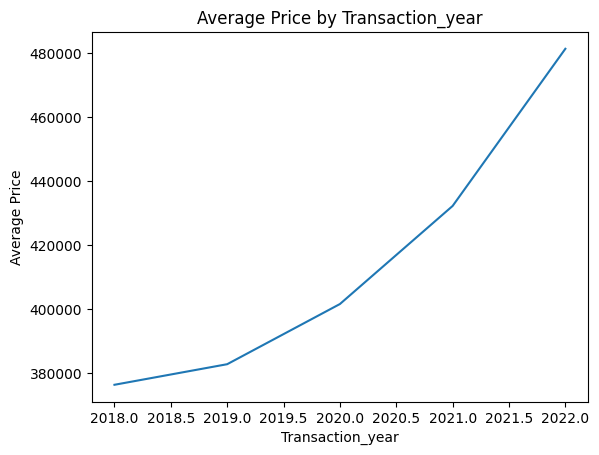

In [72]:
df = train.groupby("transaction_year").mean()["PRICE"] #average price by transaction year
df.plot()
plt.xlabel('Transaction_year')
plt.ylabel('Average Price')
plt.title('Average Price by Transaction_year')
plt.show()

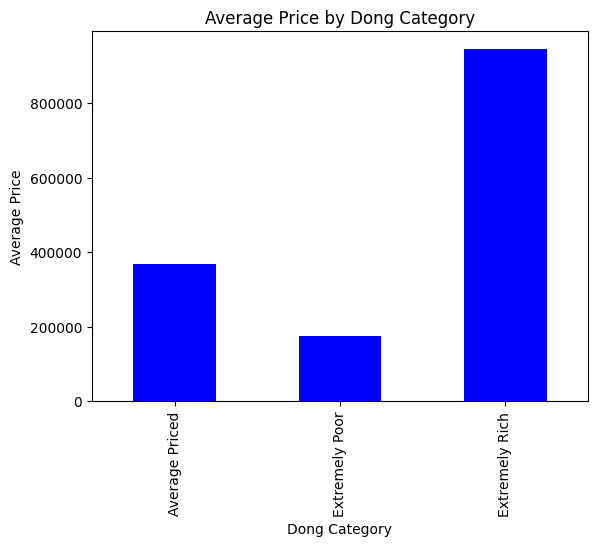

In [73]:
# Step 1: Calculate mean price for each dong
dong_mean_price = train.groupby('dong').mean()['PRICE']

# Step 2: Determine threshold values for extremely rich and extremely poor dongs
rich_threshold = dong_mean_price.quantile(0.85)
poor_threshold = dong_mean_price.quantile(0.15)

# Step 3: Assign category number to each dong
dong_category = {}
for dong, mean_price in dong_mean_price.items():
    if mean_price >= rich_threshold:
        dong_category[dong] = 'Extremely Rich'
    elif mean_price <= poor_threshold:
        dong_category[dong] = 'Extremely Poor'
    else:
        dong_category[dong] = 'Average Priced'

# Add 'dong_category' column to the train dataframe
train['dong_category'] = train['dong'].map(dong_category)

# Step 4: Plot average price by dong category
df = train.groupby('dong_category').mean()['PRICE']
df.plot(kind='bar', color='b')
plt.xlabel('Dong Category')
plt.ylabel('Average Price')
plt.title('Average Price by Dong Category')
plt.show()


In [74]:

# Normalize 'house_area'
scaler = StandardScaler()
train['house_area_scaled'] = scaler.fit_transform(train[['house_area']])
test['house_area_scaled'] = scaler.transform(test[['house_area']])


In [75]:
from sklearn.preprocessing import LabelEncoder

# Calculate mean price for each dong
dong_mean_price = train.groupby('dong').mean()['PRICE']

# Determine threshold values for extremely rich, rich, extremely poor, and poor dongs
extremely_rich_threshold = dong_mean_price.quantile(0.9)
rich_threshold = dong_mean_price.quantile(0.7)
poor_threshold = dong_mean_price.quantile(0.3)
extremely_poor_threshold = dong_mean_price.quantile(0.1)

# Assign category number to each dong
dong_category = {}
for dong, mean_price in dong_mean_price.items():
    if mean_price >= extremely_rich_threshold:
        dong_category[dong] = 'Extremely Rich'
    elif mean_price >= rich_threshold:
        dong_category[dong] = 'Rich'
    elif mean_price >= poor_threshold:
        dong_category[dong] = 'Average'
    elif mean_price >= extremely_poor_threshold:
        dong_category[dong] = 'Poor'
    else:
        dong_category[dong] = 'Extremely Poor'

# Add 'dong_category' column to the train and test datasets
train['dong_category'] = train['dong'].map(dong_category)
test['dong_category'] = test['dong'].map(dong_category)

# Perform label encoding on the 'dong_category' column
le = LabelEncoder()
train['dong_category_encoded'] = le.fit_transform(train['dong_category'])
test['dong_category_encoded'] = le.transform(test['dong_category'])


In [84]:
# Calculate mean price for each apartment_id
apartment_mean_price = train.groupby('apartment_id').mean()['PRICE']

# Determine threshold values for extremely expensive and extremely cheap apartments
expensive_threshold = apartment_mean_price.quantile(0.85)
cheap_threshold = apartment_mean_price.quantile(0.15)

# Assign category number to each apartment_id
apartment_category = {}
for apartment, mean_price in apartment_mean_price.items():
    if mean_price >= expensive_threshold:
        apartment_category[apartment] = 'Extremely Expensive'
    elif mean_price <= cheap_threshold:
        apartment_category[apartment] = 'Extremely Cheap'
    else:
        apartment_category[apartment] = 'Average Priced'

# Add 'apartment_category' column to the train and test datasets
train['apartment_category'] = train['apartment_id'].map(apartment_category)
test['apartment_category'] = test['apartment_id'].map(apartment_category)

# Perform label encoding on the 'apartment_category' column
le = LabelEncoder()
# Fill missing values in 'apartment_id' column of test dataset
missing_value = 'Average Priced'
test['apartment_category'].fillna(missing_value, inplace=True)

train['apartment_category_encoded'] = le.fit_transform(train['apartment_category'])
test['apartment_category_encoded'] = le.transform(test['apartment_category'])



In [85]:
train['transaction_year'] = train['transaction_year'] + 1

In [86]:
train_cols = ['apartment_id', 'city', 'house_area_scaled', 'built_year', 'transaction_day', 'floor', 'transaction_year', 'transaction_month', 'dong_category_encoded', 'dong', 'lat', 'long', 'apartment_category_encoded']


In [87]:
train.dtypes

index                           int64
apartment_id                    int64
city                            int64
dong                            int64
house_area                    float64
built_year                      int64
floor                           int64
lat                           float64
long                          float64
transaction_year                int64
transaction_month               int64
transaction_day                 int64
PRICE                         float64
dong_category                  object
house_area_scaled             float64
dong_category_encoded           int64
apartment_category             object
apartment_category_encoded      int64
dtype: object

In [88]:
train_columns = train.columns.tolist()  # List of column names in train dataset
test_columns = test.columns.tolist()  # List of column names in test dataset

# Compare column entries and count occurrences
for column in train_columns:
    if column in test_columns:
        train_entries = train[column].value_counts()
        test_entries = test[column].value_counts()

        print(f"Column: {column}")
        print("Train Entries:")
        print(train_entries)
        print("Test Entries:")
        print(test_entries)
        print("--------------------")


Column: index
Train Entries:
0         1
219740    1
219798    1
219797    1
219796    1
         ..
109895    1
109894    1
109893    1
109892    1
329689    1
Name: index, Length: 329690, dtype: int64
Test Entries:
329690    1
386428    1
386426    1
386425    1
386424    1
         ..
358055    1
358054    1
358053    1
358052    1
414786    1
Name: index, Length: 85097, dtype: int64
--------------------
Column: apartment_id
Train Entries:
368     1401
2707    1229
4384    1032
2772    1014
3966    1012
        ... 
2806       1
4122       1
129        1
1634       1
163        1
Name: apartment_id, Length: 4419, dtype: int64
Test Entries:
368     481
2368    383
205     316
3966    308
2772    303
       ... 
1289      1
3639      1
1953      1
1725      1
1399      1
Name: apartment_id, Length: 3957, dtype: int64
--------------------
Column: city
Train Entries:
1    186003
0    143687
Name: city, dtype: int64
Test Entries:
1    58651
0    26446
Name: city, dtype: int64
-----------

In [89]:
train_cols

['apartment_id',
 'city',
 'house_area_scaled',
 'built_year',
 'transaction_day',
 'floor',
 'transaction_year',
 'transaction_month',
 'dong_category_encoded',
 'dong',
 'lat',
 'long',
 'apartment_category_encoded']

In [90]:
test.dtypes

index                           int64
apartment_id                    int64
city                            int64
dong                            int64
house_area                    float64
built_year                      int64
floor                           int64
lat                           float64
long                          float64
transaction_year                int64
transaction_month               int64
transaction_day                 int64
house_area_scaled             float64
dong_category                  object
dong_category_encoded           int64
apartment_category             object
apartment_category_encoded      int64
dtype: object

In [91]:
train

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,PRICE,dong_category,house_area_scaled,dong_category_encoded,apartment_category,apartment_category_encoded
0,0,0,0,197,125.865988,1993,5,35.149929,129.006071,2022,7,0,229250.80,Poor,0.907747,3,Average Priced,0
1,1,0,0,197,101.647190,1993,12,35.149929,129.006071,2022,10,1,215320.00,Poor,0.221900,3,Average Priced,0
2,2,0,0,197,91.511175,1993,6,35.149929,129.006071,2021,3,5,161740.00,Poor,-0.065140,3,Average Priced,0
3,3,0,0,197,101.647190,1993,13,35.149929,129.006071,2021,5,0,199781.80,Poor,0.221900,3,Average Priced,0
4,4,0,0,197,101.647190,1993,4,35.149929,129.006071,2023,6,4,219606.40,Poor,0.221900,3,Average Priced,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329685,329685,4419,1,37,101.431912,2014,4,37.452039,127.070842,2023,5,5,885070.00,Extremely Rich,0.215803,2,Extremely Expensive,2
329686,329686,4419,1,37,101.431912,2014,14,37.452039,127.070842,2022,10,1,826132.00,Extremely Rich,0.215803,2,Extremely Expensive,2
329687,329687,4419,1,37,71.687641,2014,2,37.452039,127.070842,2023,11,4,697540.00,Extremely Rich,-0.626519,2,Extremely Expensive,2
329688,329688,4419,1,37,137.192013,2014,18,37.452039,127.070842,2021,9,4,870656.98,Extremely Rich,1.228487,2,Extremely Expensive,2


In [92]:
test

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,house_area_scaled,dong_category,dong_category_encoded,apartment_category,apartment_category_encoded
0,329690,0,0,197,101.647190,1993,3,35.149929,129.006071,2023,1,5,0.221900,Poor,3,Average Priced,0
1,329691,0,0,197,91.511175,1993,12,35.149929,129.006071,2023,2,1,-0.065140,Poor,3,Average Priced,0
2,329692,0,0,197,125.865988,1993,2,35.149929,129.006071,2023,2,0,0.907747,Poor,3,Average Priced,0
3,329693,0,0,197,101.647190,1993,8,35.149929,129.006071,2023,2,2,0.221900,Poor,3,Average Priced,0
4,329694,0,0,197,101.647190,1993,13,35.149929,129.006071,2023,3,5,0.221900,Poor,3,Average Priced,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85092,414782,4419,1,37,100.821957,2014,8,37.452039,127.070842,2023,10,5,0.198530,Extremely Rich,2,Extremely Expensive,2
85093,414783,4419,1,37,101.431912,2014,11,37.452039,127.070842,2023,10,5,0.215803,Extremely Rich,2,Extremely Expensive,2
85094,414784,4419,1,37,121.201627,2014,12,37.452039,127.070842,2023,11,1,0.775658,Extremely Rich,2,Extremely Expensive,2
85095,414785,4419,1,37,137.192013,2014,3,37.452039,127.070842,2023,11,4,1.228487,Extremely Rich,2,Extremely Expensive,2


# 4. Modeling
- We use the most popular technique `KFold Cross Validation` and `Random Forest`.

Parameter Tuning

In [93]:
from sklearn.model_selection import train_test_split

# Split the data into train and validation sets
train_x, val_x, train_y, val_y = train_test_split(train[train_cols], train['PRICE'], test_size=0.2, random_state=2023)

# Objective function
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  
        'gamma': trial.suggest_loguniform('gamma', 0.001, 1.0)  
    }
    param['tree_method'] = 'gpu_hist'  # Set tree_method to 'gpu_hist'

    model = XGBRegressor(**param)

    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=5, verbose=False,
              callbacks=[XGBoostPruningCallback(trial, 'validation_0-rmse')])  # use pruning callback

    pred = model.predict(val_x)
    score = mean_absolute_error(val_y, pred)
    return score

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)  # Decreased number of trials

best_params = study.best_trial.params
best_score = study.best_trial.value

print(f'Best params: {best_params}')
print(f'Best score: {best_score}')


[I 2023-06-05 10:24:43,999] A new study created in memory with name: no-name-d2449440-4d1f-400a-836b-5741bdc0e4c1
[I 2023-06-05 10:24:50,369] Trial 0 finished with value: 19205.15228507923 and parameters: {'n_estimators': 1317, 'learning_rate': 0.09803445636121051, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'gamma': 0.01231782771954913}. Best is trial 0 with value: 19205.15228507923.
[I 2023-06-05 10:24:51,453] Trial 1 finished with value: 76903.95777322825 and parameters: {'n_estimators': 104, 'learning_rate': 0.01806368881702031, 'max_depth': 6, 'subsample': 0.6, 'colsample_bytree': 0.7, 'min_child_weight': 2, 'gamma': 0.012730944618430351}. Best is trial 0 with value: 19205.15228507923.
[I 2023-06-05 10:24:58,882] Trial 2 finished with value: 19414.97975994637 and parameters: {'n_estimators': 724, 'learning_rate': 0.062876947380881, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 6, 'gamma': 0.44966986969323225}. 

Best params: {'n_estimators': 780, 'learning_rate': 0.09946749700495569, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 2, 'gamma': 0.5337374110233959}
Best score: 18507.29968139649


In [95]:
# Initialize the model with best parameters
model = XGBRegressor(**best_params, n_jobs=-1, tree_method='gpu_hist')

feature_importance = []
val_accs = []
test_pred = []

kf = KFold(n_splits=5, shuffle=True, random_state=2023)
for i, (tr_index, val_index) in enumerate(kf.split(train)):
    tr_x, tr_y = train[train_cols].iloc[tr_index], train.iloc[tr_index]['PRICE']
    val_x, val_y = train[train_cols].iloc[val_index], train.iloc[val_index]['PRICE']
    test_x = test[train_cols]

    model.fit(tr_x, tr_y, early_stopping_rounds=5, eval_set=[(val_x, val_y)], verbose=False)

    pred_val = model.predict(val_x)
    test_pred.append(model.predict(test_x))
    rf_acc = mean_absolute_error(val_y, pred_val)
    val_accs.append(rf_acc)
    feature_importance.append(model.feature_importances_)

    print(f'Fold{i}: XGB MAE {rf_acc:.4f}')
print(f'Average XGB MAE {np.mean(val_accs):.4f}')


Fold0: XGB MAE 20509.3999
Fold1: XGB MAE 18965.3520
Fold2: XGB MAE 18473.3903
Fold3: XGB MAE 18653.4717
Fold4: XGB MAE 18863.8860
Average XGB MAE 19093.1000


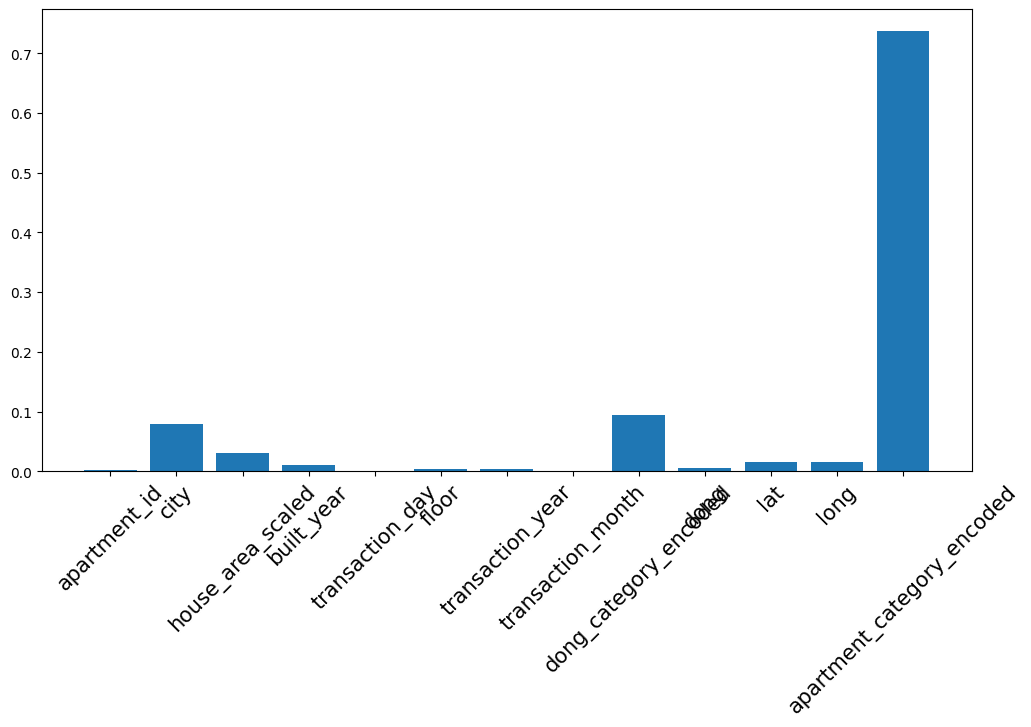

In [96]:
plt.figure(figsize=(12,6))
plt.bar(x=train_cols, height=np.mean(feature_importance, axis=0))
plt.xticks(fontsize=15, rotation=45)
plt.show()

# 5. Make submission

In [97]:
pred_test = np.mean(test_pred, axis=0)

In [103]:
print(np.mean(pred_test))

581231.25


In [100]:
inflation_rate = 0.114

In [101]:
print(inflation_rate)

0.114


In [102]:
# Adjust predicted prices based on inflation rate (assuming it has been calculated)
pred_test = pred_test * (1 + inflation_rate)

In [104]:
pd.DataFrame({'index':test['index'].values, 'PRICE':pred_test}).to_csv(os.path.join(OUTPUT_DIR, 'example1.csv'), index=False)